<a href="https://colab.research.google.com/github/Min-ju-Kim/AIFFEL_Going-Deeper/blob/main/3.%20Class%20Activation%20Map%20/%20%5BGD_6%5DClassActivationMap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Going Deeper 6. Class Activation Map

### Table of Contents

### 1. Experiment Environment Set-up
* 1.1 Import Libraries

### 2. Preparing Models for CAM, Grad-CAM
* 2.1 Prepare the Dataset
* 2.2 Object Location Information
* 2.3 Creating Model for CAM
* 2.4 Training the CAM

### 3. CAM (Class Activation Map)

### 4. Grad-CAM (Grad-Class Activation Map)

### 5. Detection with CAM
* 5.1 Bounding box
* 5.2 Intersection Over Union (IoU)

### 6. Conclusion

### 7. Retrospection

****

### 1. Experiment Environment Set-up


### 1.1 Import Libraries

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
import os
from PIL import Image

### 2. Preparing Models for CAM, Grad-CAM

### 2.1 Prepare the Dataset

* [stanford_dogs in Tensorflow Datasets](https://www.tensorflow.org/datasets/catalog/stanford_dogs)
  * Tensorflow의 데이터셋
  * 120 종의 개 사진
  * 라벨이 위치 정보인 **바운딩 박스(bounding box)** 정보를 포함

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
# 최초 수행 시에는 다운로드가 진행
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incomplete293PTH/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incomplete293PTH/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


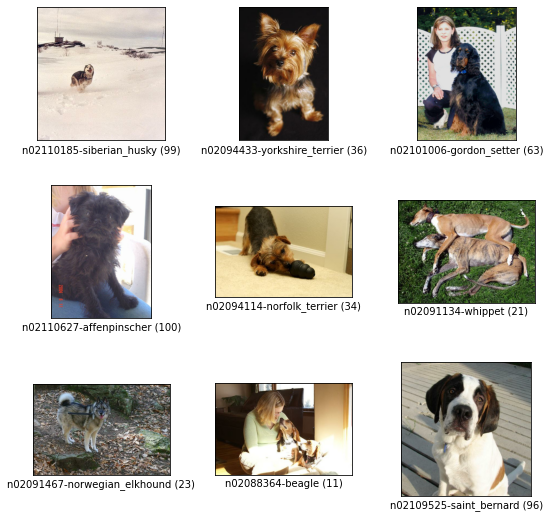

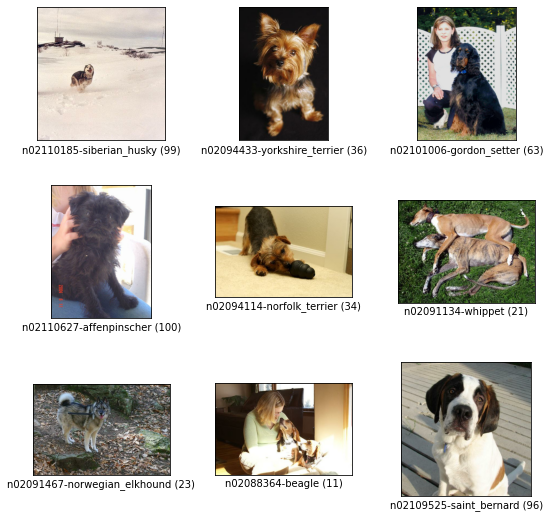

In [ ]:
# tfds.show_examples()를 통해 각 이미지의 클래스와 그 인덱스 확인 가능
tfds.show_examples(ds_train, ds_info)

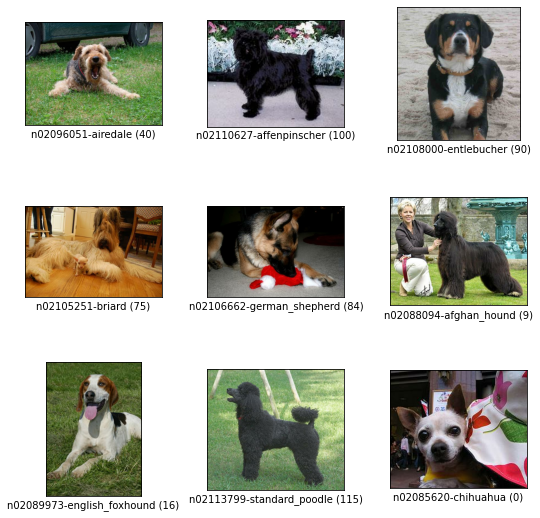

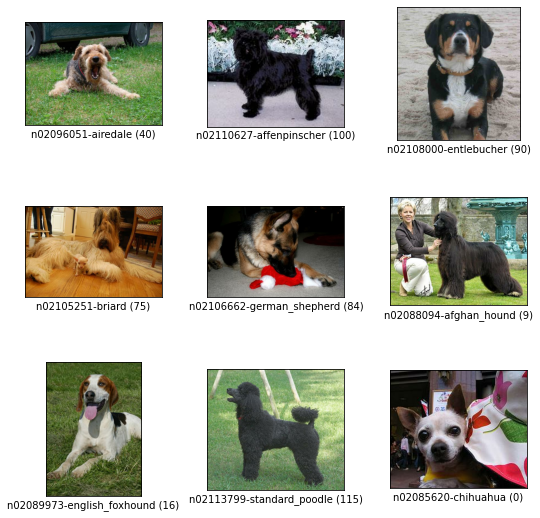

In [ ]:
# 평가용 데이터셋도 눈으로 확인해본다.
tfds.show_examples(ds_test, ds_info)

### 2.2 Object Location Information

In [ ]:
# 데이터셋의 메타정보인 df_info를 조회해 feature가 어떻게 구성되어 있는지 확인
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

* `image`와 `label`은 입력 이미지와 이미지에 해당하는 정답 클래스의 인덱스
* `bbox`(바운딩 박스)는 물체의 위치를 사각형 영역으로 표기하는 방법
* `bbox`는 `BBoxFeature`이라는 타입으로 정의
* `[y_min, x_min, y_max, x_max]`를 나타냄

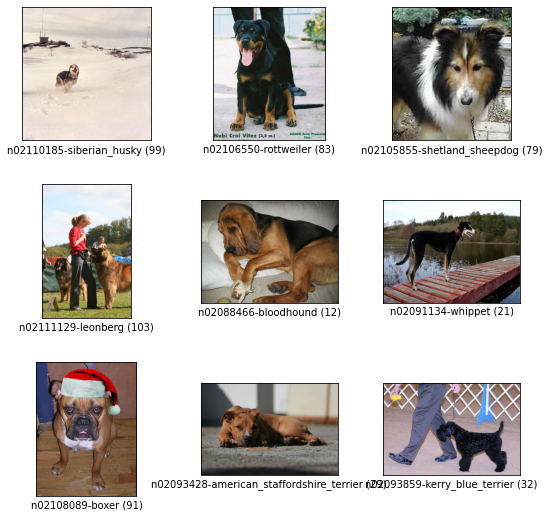

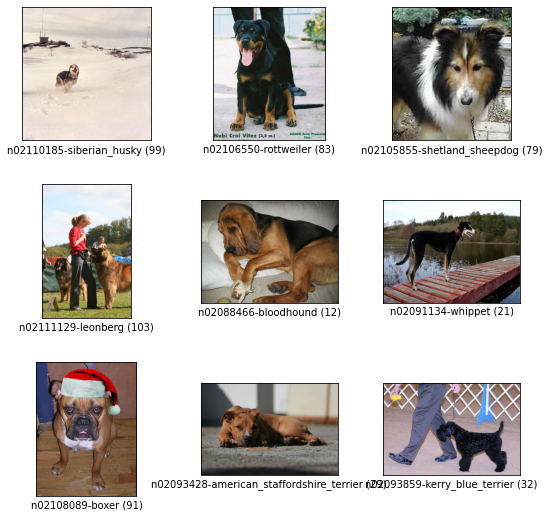

In [ ]:
# 각 이미지의 클래스와 그 인덱스 확인
tfds.show_examples(ds_train, ds_info)

### 2.3 Creating Model for CAM

* 이미지넷(ImageNet) 데이터에 훈련된 `ResNet50`을 기반
* 이후에 pooling layer 뒤에 softmax layer를 붙여 Grand-CAM 모델을 만든다.
* 여기서 사용하는 softmax layer는 softmax 함수를 activation function으로 사용하는 fully connected layer이다.

In [ ]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,  # ImageNet 분류기 fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg'  # GAP 적용
)
x = base_model.output  # base_model을 거친 결과를 의미
preds = keras.layers.Dense(num_classes, activation='softmax')(x)  # softmax 함수를 activation function으로 사용하는 fully connected layer
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

In [ ]:
# CAM model 확인
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

* conv5_block3_out의 output이 feature map이 된다. 
* 이 feature map에 GAP(Global Average Pooling)을 하여 feature의 크기를 줄이고
* 줄어든 feature 전체에 Dense layer를 붙여 classification을 수행한다.



### 2.4 Training the CAM

In [ ]:
# normalizing과 resizing을 포함한 전처리 normalize_and_resize_img() 수행
def normalize_and_resize_img(input):
    # Normalize image: `unit8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])  # 이미지 크기 224, 224로 변경
    input['image'] = tf.cast(image, tf.float32) / 255.   # 이미지 픽셀 값 0~1사이로 정규화
    return input['image'], input['label'] 

# apply_normalize_on_dataset()에서 배치 구성
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200) 
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('🌸~')

🌸~


In [ ]:
# 데이터셋에 전처리와 배치처리 적용
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

In [ ]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

print('🌸~')

🌸~


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 129s 143ms/step - loss: 2.1697 - accuracy: 0.4552 - val_loss: 3.0347 - val_accuracy: 0.2590
Epoch 2/20
750/750 [==============================] - 101s 135ms/step - loss: 0.6691 - accuracy: 0.8192 - val_loss: 1.0193 - val_accuracy: 0.6984
Epoch 3/20
750/750 [==============================] - 101s 135ms/step - loss: 0.2377 - accuracy: 0.9499 - val_loss: 0.9643 - val_accuracy: 0.7171
Epoch 4/20
750/750 [==============================] - 101s 135ms/step - loss: 0.0863 - accuracy: 0.9899 - val_loss: 0.9169 - val_accuracy: 0.7346
Epoch 5/20
750/750 [==============================] - 102s 135ms/step - loss: 0.0515 - accuracy: 0.9952 - val_loss: 0.9497 - val_accuracy: 0.7307
Epoch 6/20
750/750 [==============================] - 102s 136ms/step - loss: 0.0246 - accuracy: 0.9983 - val_loss: 0.9054 - val_accuracy: 0.7471
Epoch 7/20
750/750 [==============================] - 101s 135ms/step - loss: 0.0114 - accuracy: 0.9998 - val_loss: 0.9024 -

In [ ]:
# 학습시킨 가중치 저장
cam_model_path = '/content/sample_data.cam_model1.h5'
cam_model.save(cam_model_path)#

print('🌸~')

🌸~


### 3. CAM (Class Activation Map)

In [ ]:
import urllib3

urllib3.disable_warnings()

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

def normalize_and_resize_img(input):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [ ]:
# 학습된 모델에서 CAM 생성
# CAM 생성 작업은 데이터셋 배치 단위가 아니라 개별 이미지 데이터 단위로 이루어진다.
# 따라서 `get_one()`함수로 데이터셋에서 한 장씩 뽑을 수 있도록 했다.
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())  # numpy형태로 변환
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

print('🌸~')

🌸~


108


<function matplotlib.pyplot.show>

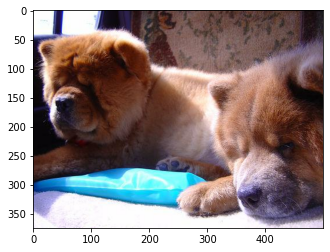

In [ ]:
# 데이터 하나를 가져와 시각화
item = get_one(ds_test)  # ds_test를 집어넣는다(normalize, resize 적용하지 X), numpy형태로 변환된다.
print(item['label'])
plt.imshow(item['image'])
plt.show

In [ ]:
# 데이터 준비가 완료되었으므로 학습한 모델 불러오기
cam_model.save(cam_model_path)

print('🌸~')

🌸~


<p align='middle'><img src = 'https://media.vlpt.us/images/mjk3136/post/60e1a691-e245-437e-bef2-194d582fecb2/image.png' width='650'></p>

* CAM을 생성하기 위해 필요한 것
1. 특성 맵
2. 클래스별 확률을 얻기 위한 소프트맥스 레이어의 가중치
3. 원하는 클래스의 출력값

| Layer (type) | Output Shape | Param # | Connected to | - |
| :--: | :--: | :--: | :--: | :--: | 
|conv5_block3_out (Activation) | (None, 7, 7, 2048) | 0 | conv5_block3_add[0][0] | (activation map) |           
|avg_pool (GlobalAveragePooling2) | (None, 2048) | 0 | conv5_block3_out[0][0] | - |           
|dense (Dense) | (None, 120) | 245880 | avg_pool[0][0] | (softmax layer) |

In [ ]:
def generate_cam(model, item):  # 여기서 item은 `get_one`함수를 통과한 후의 결과값
    item = copy.deepcopy(item)  # 파이썬 내장 클래스 copy
    # image.shape = (height, width, channels)  list아닌가?
    width = item['image'].shape[1]
    height = item['image'].shape[0]

    # normalize_and_resize_img의 return값 : input['image'], input['label']
    # img_tensor(type:tensor, shape:(224, 224, 3)) = item['image'], class_idx(type:tensor, shape:(1, 120)) = item['label']
    img_tensor, class_idx = normalize_and_resize_img(item)  

    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의
    # model.layer[-3].output : GAP 이전 Convolution layer의 output (activation map)
    # cam_model = keras.Model(input=base_model.input, outputs=preds)
    # conv_outputs = activation map
    # predicts = softmax layer를 통과한 output
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])  # 모델의 input과 output을 새롭게 정의 
    conv_outputs, predicts = cam_model(tf.expand_dims(img_tensor, 0))  # tf.expand_dims(img_tensor, 0) : [1, -, -, -] / [-, -, -] : img_tensor.shape
    
    conv_outputs = conv_outputs[0, :, :, :]  # 앞에서 추가했던 축을 제외하고 받아온다. ((7, 7, 2048))
    class_weights = model.layers[-1].get_weights()[0]  # 마지막 모델의 weight activation을 가져온다. (softmax의 가중치)
                                                       # get_weights()[1] 의 경우 bis 해당
                                                       # class_weight: shape = (2048, 120), type = numpy.ndarray
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])  # conv_outputs.shape[0:2] = (7, 7)
    for i, w in enumerate(class_weights[:, class_idx]):  # class_weights[:, class_idx] = 행은 전부 다, 열은 class_idx에 해당하는 열을 가져온다. (2048,)
        # W*f를 통해 class별 activation map을 계산한다.
        cam_image += w * conv_outputs[:, :, i]  
    
    cam_image /= np.max(cam_image)  # activation score를 normalize한다.
    cam_image = cam_image.numpy()  
    cam_image = cv2.resize(cam_image, (width, height))  # 원래 이미지의 크기로 resize
    return cam_image

print('🌸~')

🌸~


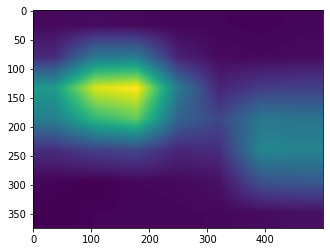

In [ ]:
# CAM 이미지 확인
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [ ]:
# 그려진 CAM 이미지를 원본 이미지와 합쳐본다.
def visualize_cam_on_img(src1, src2, alpha=0.5):
    beta = (1.0-alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

print('🌸~')

🌸~


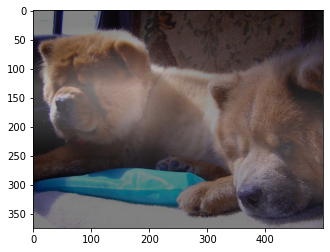

In [ ]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_img(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

### 4. Grad-CAM (Grad-Class Activation Map)

67


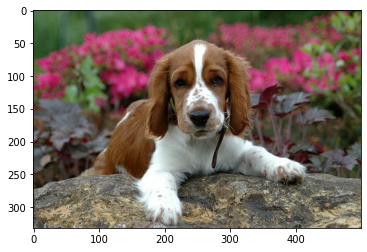

In [ ]:
# 우선 새로운 이미지를 뽑아본다.
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

* `grad_cam`은 관찰을 원하는 레이어와 정답 클래스에 대한 예측값 사이의 그래디언트를 구하고,
* 여기에 GAP 연산을 적용함으로써 관찰 대상이 되는 레이어의 채널별 가중치를 구한다.
* 최종 CAM 이미지를 구하기 위해서는 레이어의 채널별 가중치(`weights`)와 레이어에서 나온 특성별 특성 맵을 가중합해주어 `cam_image`를 얻게 된다.

* 그래디언트 계산을 원하는 관찰 대상 레이어 `activation_layer`를 뽑아서 쓸 수 있도록 `activation_layer`의 이름을 받고 이를 활용해야 한다.
* `generate_grad_cam()`에서는 원하는 레이어의 `output`과 특정 클래스의 prediction 사이의 그래디언트 `grad_val`을 얻고 이를 `weights`롤 활용한다.

<p align='middle'><img src='https://d3s0tskafalll9.cloudfront.net/media/images/GC-3-L-9.max-800x600.png' height='230'></p>

In [ ]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)

    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])

    # Gradient를 얻기 위해 tape를 사용한다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor,0))

        loss = pred[:, class_idx]  # 원하는 class(여기서는 정답으로 활용) 예측값을 얻는다.
        output = conv_output[0]  # 원하는 layer의 output을 얻는다.
        grad_val = tape.gradient(loss, conv_output)[0]  # 예측값에 따른 Layer의 gradient를 얻는다.

    weights = np.mean(grad_val, axis=(0,1))  # gradient의 GAP으로 class별 weight를 구한다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻는다.
        grad_cam_image += w * output[:, :, k]
    
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

print('🌸~')

🌸~


* 레이어의 이름은 이전 스탭의 `cam_model.summary()` 결과에서 찾을 수 있다. 

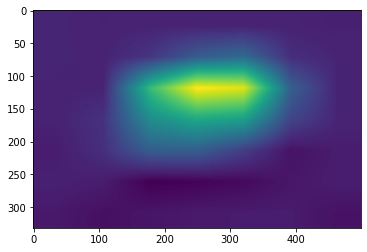

In [ ]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

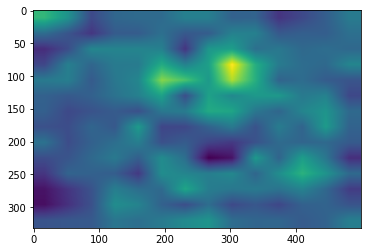

In [ ]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

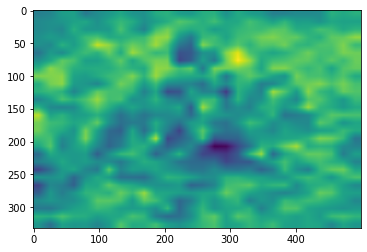

In [ ]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

### 5. Detection with CAM

### 5.1 Bounding box

67


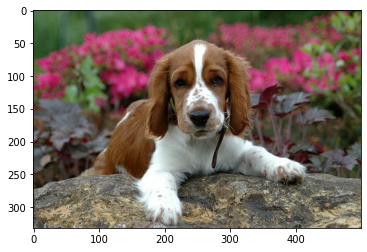

In [ ]:
# 우선 새로운 이미지를 다시 뽑아 CAM 이미지를 뽑아본다.
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

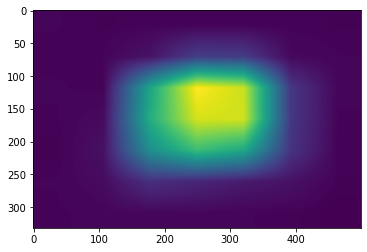

In [ ]:
# 이전 스텝에서 만들었던 `generate_cam()`을 활용해서 CAM 이미지를 뽑는다. 
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

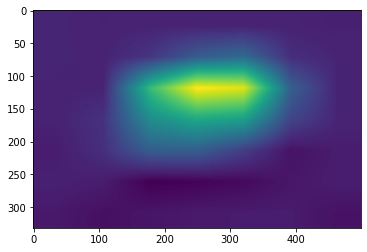

In [ ]:
# 이전 스텝에서 만들었던 `generate_grad_cam()`을 활용해서 Grad-CAM 이미지를 뽑는다. 
# 특성 맵을 뽑아오는 위치는 CAM과 동일하게 설정
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

* `get_bbox()`함수는 바운딩 박스를 만들기 위해 `score_thresh`를 받아 역치값 이하의 바운딩 박스는 없앤다.
* OpenCV의 `findContours()`와 `minAreaRect()`로 사각형을 찾는다.
* 이때 `rotated_rect`라는 회전된 바운딩 박스를 얻을 수 있다.
* `boxPoints()`로 이를 꼭지점으로 바꾸어 준다.
* 마지막에는 `int` 자료향으로 변환해준다.

In [ ]:
def get_bbox(cam_image, score_thresh=0.5):
    low_indicies = cam_image <= score_thresh  # 역치값 이하의 바운딩 박스는 없앤다.
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)

    # 윤곽선만 변수 contours로 받아온다.
    contours, _ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)  # 최소한의 사각형 표시, 회전된 바운딩 박스 얻기
    rect = cv2.boxPoints(rotated_rect)  # 중심점과 각도를 4개의 꼭지점 좌표로 변환
    rect = np.int0(rect)  # 정수로 변환
    return rect

print('🌸~')

🌸~


In [ ]:
# CAM의 bbox를 얻는다.
rect = get_bbox(cam_image)
rect

array([[165, 227],
       [165,  90],
       [360,  90],
       [360, 227]])

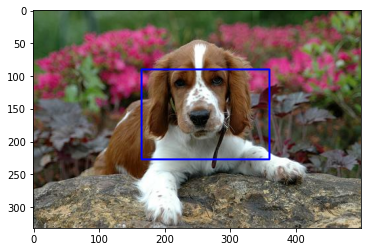

In [ ]:
# 얻어진 bbox를 이미지 위에 시각화한다.
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0, 0, 255), 2)
plt.imshow(image)
plt.show()

In [ ]:
# Grad-CAM의 bbox를 얻는다.
grad_rect = get_bbox(grad_cam_image)
grad_rect

array([[164, 175],
       [162,  90],
       [364,  85],
       [366, 170]])

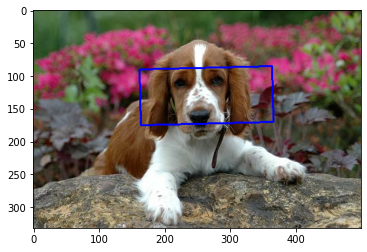

In [ ]:
# 얻어진 bbox를 이미지 위에 시각화한다.
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [grad_rect], 0, (0, 0, 255), 2)
plt.imshow(image)
plt.show()

### 5.2 Intersection Over Union (IoU)

<p align='middle'><img src='https://d3s0tskafalll9.cloudfront.net/media/images/GC-3-P-3.max-800x600.jpg' width='300'></p>

* 정답 데이터인 바운딩 박스와 비교하는 방법
* 두 영역의 교집합인 **intersection** 영역의 넓이를 두 영역의 합집합인 **union** 영역으로 나누어준 값
* 영역을 정확하게 잘 찾아내었는지의 상대적인 비율을 구할 수 있으므로, 모델이 영역을 잘 찾았는지 비교하는 좋은 지표가 된다.

In [ ]:
# rect의 좌표는 (x, y) 형태
# bbox는 (y_min, x_min, y_max, x_max)의 normalize 형태
# image.shape = [height, width, channels]
# rect[:,1] : 4개의 y좌표
# rect[:,0] : 4개의 x좌표
def rect_to_minmax(rect, image):
    bbox = [
            rect[:,1].min()/float(image.shape[0]),  # bounding box의 y_min
            rect[:,0].min()/float(image.shape[1]),  # bounding box의 x_min
            rect[:,1].max()/float(image.shape[0]),  # bounding box의 y_max
            rect[:,0].max()/float(image.shape[1])   # bounding box의 x_max          
    ]
    return bbox

print('🌸~')

🌸~


In [ ]:
# 이 데이터의 ground truth bbox 확인
item['objects']['bbox']

array([[0.13554217, 0.146     , 0.9879518 , 0.826     ]], dtype=float32)

In [ ]:
# CAM의 bbox
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.2710843373493976, 0.33, 0.6837349397590361, 0.72]

In [ ]:
# Grad-CAM의 bbox
grad_pred_bbox = rect_to_minmax(grad_rect, item['image'])
grad_pred_bbox

[0.2560240963855422, 0.324, 0.5271084337349398, 0.732]

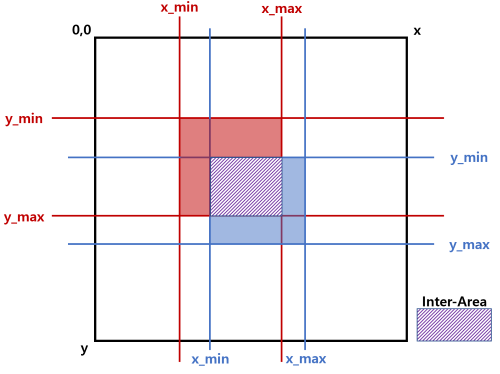

In [ ]:
# IoU 계산
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min = max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])

    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

print('🌸~')

🌸~


In [ ]:
# CAM으로 얻은 바운딩 박스와 정답 바운딩 박스와의 IoU
get_iou(pred_bbox, item['objects']['bbox'][0])

0.277644986706671

In [ ]:
# Grad-CAM으로 얻은 바운딩 박스와 정답 바운딩 박스와의 IoU
get_iou(grad_pred_bbox, item['objects']['bbox'][0])

0.19081272528296758

### 6. Conclusion

* 좌표만 확인했을 시 CAM, Grad-CAM의 바운딩 박스와 정답 바운딩 박스의 좌표가 크게 차이나지 않는다.
* IoU 확인 시 Grad-CAM보다 CAM이 정답 바운딩 박스와 더 겹치는 부분이 많음을 알 수 있다.
* Grad-CAM의 경우가 이미지의 특성 부분에 더 집중되는 경향이 있는 것 같다.
* CAM과 Grad-CAM의 특성 맵을 얻어내는 방식에 약간 차이가 있으나 결과물은 크게 차이가 없음을 알 수 있다. (출력된 특성맵 및 IoU확인 시)

### 7. Retrospection

### 7.1 What was difficult

* 좌표값을 바운딩 박스로 표현하기 위해 변환시키는 부분이 좀 어려웠다.

### 7.2 What I found out

1. `Model.fit(verbose='auto')`
* verbose: 'auto', 0, 1, or 2 
* Verbosity mode. 
* 0 = silent, 
* 1 = progress bar, 
* 2 = one line per epoch
* 'auto' defaults to 1 for most cases, but 2 when used with ParameterServerStrategy

2. `tf.data.Dataset.as_numpy_iterator()`
* 데이터 세트의 모든 요소를 ​​numpy로 변환한 iterator를 반환한다.

3. Deepcopy
* 얕은 복사와 깊은 복사의 차이점은 복합 객체 (목록 또는 클래스 인스턴스와 같은 다른 객체를 포함하는 객체)에만 해당된다.
  * 얕은 복사본은 새 복합 개체를 구성한 다음 가능한 한 원본 개체에서 찾은 개체에 참조를 삽입한다.
  * 딥 카피는 새 복합 객체를 구성한 다음 재귀 적으로 원본에서 찾은 객체의 카피를 복사한다.
* https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=websearch&logNo=222140334361

4. `tf.expand_dims()`
```python
tf.expand_dims(
    input, axis, name=None
)
```
* 인덱스 축에 길이 1 축이 삽입된 텐서를 반환한다.
* 예시
```python
>>> image = tf.zeros([10,10,3])
>>> tf.expand_dims(image, axis=0).shape.as_list()
[1, 10, 10, 3]
>>> tf.expand_dims(image, axis=1).shape.as_list()
[10, 1, 10, 3]
>>> tf.expand_dims(image, -1).shape.as_list()
[10, 10, 3, 1]
```

5. `numpy.zeros()`
```python
numpy.zeros(shape, dtype=float, order='C', *, like=None)
```
* 0으로 채워진 지정된 모양과 유형의 새 배열을 반환한다.  
  * `shape` : (int or tuple of ints) Shape of the new array, e.g., (2, 3) or 2.
  * `dtype` : (data-type, optional) The desired data-type for the array, e.g., numpy.int8. Default is numpy.float64.
  * `order` : ({‘C’, ‘F’}, optional, default: ‘C’) Whether to store multi-dimensional data in row-major (C-style) or column-major (Fortran-style) order in memory.

6. `get_weights()`
* 레이어의 현재 가중치를 NumPy 배열로 반환한다.

7. `numpy.stack()`
```python
numpy.stack(arrays, axis=0, out=None)
```
* 새 축을 따라 배열 시퀀스를 결합한다.
* axis 매개변수는 결과 차원에서 새 축의 인덱스를 지정한다. 예를 들어 axis=0이면 첫 번째 차원이 되고 axis=-1이면 마지막 차원이 된다.
  * arrays : (sequence of array_like) Each array must have the same shape.
  * axis : (int, optional) The axis in the result array along which the input arrays are stacked.
  * out : (ndarray, optional) If provided, the destination to place the result. 

8. `tf.GradientTape()`
* 자동 미분(주어진 입력 변수에 대한 연산의 그래디언트(gradient)를 계산하는 것)을 계산한다. 
* tf.GradientTape는 컨텍스트(context) 안에서 실행된 모든 연산을 테이프(tape)에 "기록"한다.
*  연산을 기록한 후에는 `GradientTape.gradient(target, sources)`를 사용하여 일부 소스(종종 모델 변수)에 상대적인 일부 대상(종종 손실)의 그래디언트를 계산한다. 

9. `cv2.findContours()`
```python
contours, hierarchy = cv2.findContours(src, mode, method, contours, hierarchy, offset)
```
* src: 입력 영상, 검정과 흰색으로 구성된 바이너리 이미지
* mode: 컨투어 제공 방식 
* method: 근사 값 방식 
* contours(optional): 검출한 컨투어 좌표 (list type)
* hierarchy(optional): 컨투어 계층 정보 (Next, Prev, FirstChild, Parent, -1 [해당 없음])
* offset(optional): ROI 등으로 인해 이동한 컨투어 좌표의 오프셋
* 반환값으로 윤곽선, 계층 구조를 반환한다.
* 윤곽선은 Numpy 구조의 배열로 검출된 윤곽선의 지점들이 담겨있다.
* 계층 구조는 윤곽선의 계층 구조를 의미한다. 각 윤곽선에 해당하는 속성 정보들이 담겨있다.
* 참조 사이트
  * https://076923.github.io/posts/Python-opencv-21/
  * https://bkshin.tistory.com/entry/OpenCV-22-%EC%BB%A8%ED%88%AC%EC%96%B4Contour

**[검색 방법]**
* `cv2.RETR_EXTERNAL` : 가장 바깥쪽 라인만 생성
* `cv2.RETR_LIST` : 모든 라인을 계층 없이 생성
* `cv2.RETR_CCOMP` : 모든 라인을 2계층으로 생성
* `cv2.RETR_TREE` : 모든 라인의 모든 계층 정보를 트리 구조로 생성

**[근사화 방법]**
* `cv2.CHAIN_APPROX_NONE` : 근사 없이 모든 좌표 제공
* `cv2.CHAIN_APPROX_SIMPLE` : 컨투어 꼭짓점 좌표만 제공
* `cv2.CHAIN_APPROX_TC89_L1` : Teh-Chin 알고리즘으로 좌표 개수 축소
* `cv2.CHAIN_APPROX_TC89_KCOS` : Teh-Chin 알고리즘으로 좌표 개수 축소

**[계층 구조]**
* 계층 구조는 윤곽선을 포함 관계의 여부를 나타낸다.
* 즉, 외곽 윤곽선, 내곽 윤곽선, 같은 계층 구조를 구별할 수 있다.
* 이 정보는 hierarchy에 담겨있다.

10. `Cv2.MinAreaRect()`
* 최소 면적 사각형 함수
* `Cv2.MinAreaRect(윤곽선 배열)`로 윤곽선의 경계면을 둘러싸는 최소 크기의 사각형을 계산한다.
* 최소 면적 사각형 함수는 `RotatedRect` 구조체를 반환한다.

11. `cv2.boxPoints()`
```python
vertex = cv2.boxPoints(rotateRect)
```
* rotateRect로부터 꼭짓점 좌표 계산
* vertex: 4개의 꼭짓점 좌표, 소수점 포함이므로 정수 변환 필요

12. `cv2.drawContours()`
```python
cv2.drawContours(img, contours, contourIdx, color, thickness)
```
* 윤곽선 그리기
* img: 입력 영상
* contours: 그림 그릴 컨투어 배열 (`cv2.findContours()` 함수의 반환 결과를 전달해주면 됨)
* contourIdx: 그림 그릴 컨투어 인덱스, -1: 모든 컨투어 표시
* color: 색상 값
* thickness: 선 두께, 0: 채우기

13. `np.int0()`
* https://stackoverflow.com/questions/48350693/what-is-numpy-method-int0

### 7.3 What I want to know more about

* CAM과 직접적인 비교를 위해 Grad-CAM에서 특성 맵을 가져올 때 `conv5_block3_out`부분의 특성 맵을 가져와 확인했다.
* 다른 layer 부분에서 특성 맵을 가져와 바운딩 박스를 그려 비교해보는 것도 재밌을 것 같다.

### 7.4 Self-Resolution

* Exploration 할 때 Feature map을 직접 출력해보고 싶었었는데 이번 기회에 직접 해보니 재밌었다.
* LMS 내용들이 옛날 자료들이 많아 최근 자료들은 직접 찾아봐야 할 것 같다. 